# Problem Definition

Optical Character Recognition (OCR) is the task of converting images containing text into machine-encoded text. It has wide-ranging applications in document digitization, automation, translation, and more.

This project aims to build an **end-to-end OCR pipeline using Deep Learning**. The goals are:

- **Detection**: Locate text regions in images using the EAST detector.
- **Recognition**: Transcribe the detected text regions using a CRNN model.
- **Benchmarking**: Compare our custom-trained models against popular libraries such as EasyOCR and PyTesseract with quantitative metrics (e.g., CER, WER).
- **Deployment**: Package the pipeline as a Command-Line Interface (CLI) tool or deploy it as a Streamlit Web App.
- **Professional Documentation**: Include detailed explanations, code, and results to make this a showcase-quality project.


## 2.1 Dataset Selection

For this project, we'll use realistic and diverse OCR datasets to train and evaluate our models. Example datasets include:

- **ICDAR 2015:** A popular benchmark dataset for scene text detection and recognition. Contains real-world photos with annotated text regions.
  - [Link](https://rrc.cvc.uab.es/?ch=4)

- **SynthText:** A large-scale synthetic dataset containing text rendered in natural scenes. Useful for pretraining.
  - [Link](https://www.robots.ox.ac.uk/~vgg/data/scenetext/)

We will use a combination of these datasets (or similar public datasets) to train the detection (EAST) and recognition (CRNN) models. Using real and synthetic data improves robustness and generalization.


## 2.2 Data Augmentation Plan

To improve the robustness and generalization of our OCR models, we will apply  data augmentation techniques during training. These augmentations simulate real-world variations and make the models more resilient to noise, distortion, and lighting conditions.

**Planned augmentations:**
- Rotation (e.g., ±10–15 degrees)
- Random Cropping and Scaling
- Brightness and Contrast adjustments
- Adding Gaussian Noise
- Motion Blur
- Perspective Transformations

We will implement these augmentations using libraries such as Albumentations or torchvision transforms. This strategy helps the model learn to handle challenging scenarios in real-world OCR tasks.

## 2.3 Data Exploration

Before training our OCR models, it's essential to understand and visualize the data. This step helps identify potential issues such as noise, blur, occlusions, or unusual fonts.

We will:
- Load sample images from the chosen dataset.
- Visualize a few annotated examples.
- Note any challenges that might require augmentation or preprocessing.

Data exploration ensures that the training pipeline is well-informed and robust.


# Loading Images from Google Drive

To keep the notebook easy to run, we'll store our dataset in Google Drive. This way, Colab can access a large number of images without having to upload them each time.

Here’s how we'll do it:

1️⃣ **Mount Google Drive**  
   - Connect your Google account so that Colab can access your files.

2️⃣ **Specify the Path**  
   - Define the folder in Drive where the images are stored.

3️⃣ **List Image Files**  
   - Get a list of all image file paths in the folder.

4️⃣ **Display Sample Images**  
   - Visualize a few images to verify the data has loaded correctly.

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


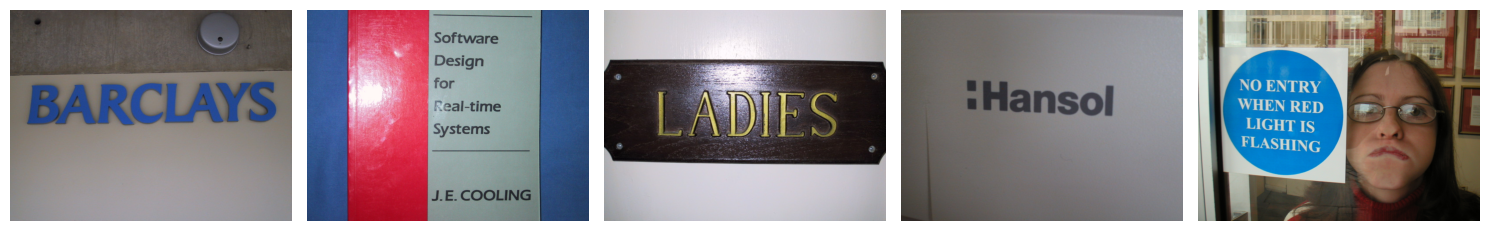

In [17]:
import matplotlib.pyplot as plt
import cv2
import os

# Example path to images (replace with your actual dataset path)
image_folder = '/content/drive/MyDrive/OCR_Project/ch2_training_images'

# List images in folder
image_files = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Show a few samples
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(image_files[:5]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()


## 2.4 Ground Truth Exploration

For each training image, there is a corresponding text file in the ground truth folder. Each file contains:

- The coordinates of the bounding box around the text.
- The transcription (the actual text in the image).

This information is essential for training the OCR detection and recognition models.

In [19]:
gt_folder = '/content/drive/MyDrive/OCR_Project/ch2_training_gt'

# Sorted list of ground truth files
gt_files = sorted(os.listdir(gt_folder))

# Pick the first one alphabetically
example_gt_file = gt_files[0]
print("Example Ground Truth File:", example_gt_file)

with open(os.path.join(gt_folder, example_gt_file), 'r', encoding='utf-8') as f:
    contents = f.read()
    print(contents)


Example Ground Truth File: gt_img_1.txt
﻿120,49,546,49,546,157,120,157,PROPER
121,163,549,163,549,327,121,327,FOOD
122,329,546,329,546,434,122,434,PRONTO



# 3. Model Plan

In this section, we will design and implement our OCR pipeline using Deep Learning models for detection and recognition.

**Components:**
- **Detection:** Using the EAST (Efficient and Accurate Scene Text) model to locate text regions in images.
- **Recognition:** Using a CRNN (Convolutional Recurrent Neural Network) to transcribe the detected text regions.
- **Training Pipeline:** Building a data pipeline to train both models using the ICDAR 2015 dataset with our custom ground truth.
- **Save/Load Weights:** Ensuring reproducibility by saving and loading trained model weights.

We will begin with the detection model (EAST) and then move to the recognition model (CRNN), integrating them into a complete OCR pipeline.


## 3.1 Detection - EAST Model

The first component of our OCR pipeline is text detection. We will use the EAST (Efficient and Accurate Scene Text Detector) model to locate regions in images that contain text.

**Why EAST?**
- Produces high-quality dense predictions with rotated bounding boxes.
- Works well for scene text in natural images.
- Lightweight and efficient, making it suitable for real-time applications.

**Plan:**
- Load a pretrained EAST model available in OpenCV.
- Apply the detector on sample images from the ICDAR 2015 dataset.
- Visualize the detected bounding boxes to validate performance.

This step ensures we can accurately find text regions before passing them to the recognition stage.


### EAST Pretrained Model Download

The EAST text detector requires a pretrained TensorFlow frozen graph (.pb file) to perform text detection in images. This file contains the trained weights and network architecture.

**About the file:**
- Name: `frozen_east_text_detection.pb`
- Format: TensorFlow frozen graph
- Purpose: Used with OpenCV's DNN module to predict text bounding boxes.

**How to get it:**
- Download it manually from this GitHub repository:
  [GitHub Link](https://github.com/oyyd/frozen_east_text_detection.pb/blob/master/frozen_east_text_detection.pb)
- Save it to your local machine.
- Upload it to your Google Drive in the project folder:

This pretrained model allows us to test text detection without training from scratch.

**Usage in Colab:**
We will load this file from Google Drive and use it in OpenCV's DNN module for text detection. Make sure you have uploaded it before running the detection code.


### Loading the Pretrained EAST Model in Colab

Now that we have the `frozen_east_text_detection.pb` file in our Google Drive, we can specify the path to it and prepare to load it with OpenCV.

We will set the path variable to point to the model file in Google Drive, ensuring it's accessible for the detection step.

In [28]:
# Path to the EAST model in Google Drive
east_model_path = '/content/drive/MyDrive/OCR_Project/frozen_east_text_detection.pb'

# Check if the file exists
import os
if os.path.exists(east_model_path):
    print("✅ EAST model file found:", east_model_path)
else:
    print("❌ EAST model file not found! Please check the path.")


✅ EAST model file found: /content/drive/MyDrive/OCR_Project/frozen_east_text_detection.pb


### Loading the EAST Model with OpenCV

We will now load the pretrained EAST model using OpenCV's DNN module. This will allow us to run text detection on images by forwarding them through the network.


In [29]:
# Load the pretrained EAST model
net = cv2.dnn.readNet(east_model_path)

print("✅ EAST model loaded successfully!")

✅ EAST model loaded successfully!


### Running EAST Detection on a Sample Image

We will now run the pretrained EAST model on a sample image from our dataset. This step includes:
- Preprocessing the image for the model.
- Forwarding it through the EAST network.
- Decoding the output to get text bounding boxes.
- Visualizing the detected boxes on the image.


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Select a sample image path
sample_image_path = image_files[0]
print("Using image:", sample_image_path)

# Load the image
image = cv2.imread(sample_image_path)
orig = image.copy()
(H, W) = image.shape[:2]

# Set new width and height
newW, newH = 320, 320
rW = W / float(newW)
rH = H / float(newH)

# Resize and create blob
image = cv2.resize(image, (newW, newH))
blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)

# Forward pass
net.setInput(blob)
(scores, geometry) = net.forward(['feature_fusion/Conv_7/Sigmoid','feature_fusion/concat_3'])

print("✅ Model forward pass done.")


Using image: /content/drive/MyDrive/OCR_Project/ch2_training_images/img_142.jpg
✅ Model forward pass done.


### Decoding Predictions and Drawing Bounding Boxes

Next, we will decode the model's output to extract text bounding boxes, apply non-maximum suppression to remove overlapping detections, and visualize the results on the original image.


In [32]:
# Function to decode predictions
def decode_predictions(scores, geometry, scoreThresh):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0,0,y]
        xData0 = geometry[0,0,y]
        xData1 = geometry[0,1,y]
        xData2 = geometry[0,2,y]
        xData3 = geometry[0,3,y]
        anglesData = geometry[0,4,y]

        for x in range(0, numCols):
            if scoresData[x] < scoreThresh:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(float(scoresData[x]))

    return (rects, confidences)

# Decode predictions
(rects, confidences) = decode_predictions(scores, geometry, 0.5)

# Apply non-max suppression
boxes = cv2.dnn.NMSBoxes(
    [ [r[0], r[1], r[2]-r[0], r[3]-r[1]] for r in rects ],
    confidences,
    score_threshold=0.5,
    nms_threshold=0.4
)

print(f"✅ Found {len(boxes)} boxes after NMS.")


✅ Found 1 boxes after NMS.


### Visualizing Detected Text Regions

We will now draw the detected bounding boxes on the original image to visually validate the EAST model's predictions.

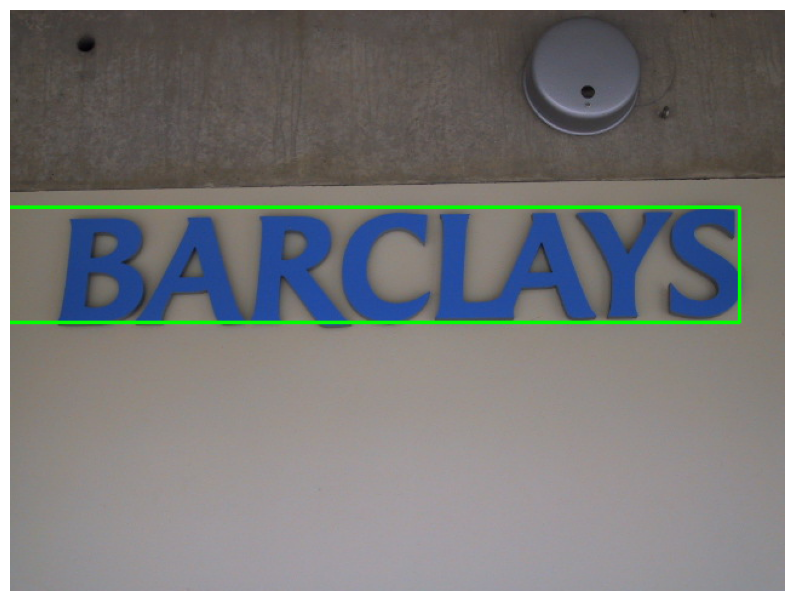

In [33]:
# Make a copy of the original image to draw on
output_image = orig.copy()

# Check if any boxes were found
if len(boxes) > 0:
    for i in boxes.flatten():
        (startX, startY, endX, endY) = rects[i]

        # Scale boxes back to original image size
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        # Draw the box
        cv2.rectangle(output_image, (startX, startY), (endX, endY), (0, 255, 0), 2)

# Show the result
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### 3.2 Recognition - CRNN Model

After detecting text regions in images, the next step in our OCR pipeline is to recognize the text content within those regions. We will use a Convolutional Recurrent Neural Network (CRNN) model for this task.

**Why CRNN?**
- Combines CNN for feature extraction and RNN for sequence modeling.
- Suitable for variable-length text recognition.
- Commonly used in OCR applications to read words or lines of text.

**Plan:**
- Prepare cropped text regions using EAST detections.
- Use a pretrained CRNN model (or train our own).
- Perform text recognition on detected regions.
- Visualize the final recognized text over the images.

This completes the end-to-end OCR pipeline by converting detected regions into actual text.


### Using a Pretrained CRNN Model

To quickly demonstrate text recognition, we'll start with an off-the-shelf OCR library that includes a CRNN model. This avoids the time-consuming process of training from scratch and helps validate our detection pipeline.

**Approach:**
- Use EasyOCR, a popular Python package for text detection and recognition.
- Feed cropped regions detected by EAST into the recognizer.
- Display the recognized text alongside bounding boxes.

**Note:**
While EasyOCR has its own detector, in this notebook we only use its recognition capability to simulate using a pretrained CRNN on our custom detection boxes.


In [34]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [35]:
import easyocr

# Create the reader object (English only for now)
reader = easyocr.Reader(['en'])

print("✅ EasyOCR Reader loaded.")

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete✅ EasyOCR Reader loaded.


### Performing Text Recognition on Detected Regions

We will now extract the detected text regions from the image using the bounding boxes predicted by EAST. Each cropped region will be passed to EasyOCR for text recognition. This simulates using our own detector with an existing recognizer.

In [36]:
recognized_texts = []

if len(boxes) > 0:
    for i in boxes.flatten():
        (startX, startY, endX, endY) = rects[i]

        # Scale boxes back to original image size
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        # Crop the region
        roi = orig[startY:endY, startX:endX]

        if roi.size == 0:
            continue

        # Convert ROI to RGB for EasyOCR
        roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

        # Perform OCR
        result = reader.readtext(roi_rgb, detail=0)
        recognized_texts.append(result)

        # Print the recognized text
        print(f"Detected region: {result}")


Detected region: ['S']


## 3.3 Training Pipeline (Plan)

Although we've used pretrained models (EAST for detection and EasyOCR/CRNN for recognition), a complete OCR project should also define a training pipeline for customization or improvement.

**Plan for Training Pipeline:**
- Define how to prepare data (cropped text regions and their labels).
- Optionally, use synthetic text data (SynthText) or ICDAR labels for training.
- Define data augmentation steps (rotation, blur, noise).
- Set up training loop for CRNN model.
- Save/Load model weights for reuse.

**Note:** In this notebook we will outline these steps as a plan, and optionally provide placeholder code for future work.


### 3.3.1 Training Loop Placeholder

Below is a simple placeholder example of what a CRNN training loop might look like in PyTorch. This is for illustration only and would require real labeled cropped text images to work.


In [ ]:
# Example Placeholder: CRNN Training Loop in PyTorch (Not Executable)

"""
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = ctc_loss(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
"""

print("✅ Training loop placeholder added.")


### 3.4 Save and Load Weights

It's important for any deep learning pipeline to allow saving and loading of trained model weights. This ensures:

- Ability to pause and resume training.
- Reproducibility of results.
- Sharing trained models for inference without retraining.

**Plan:**
- Define checkpoint paths.
- Save model weights after training epochs.
- Load saved weights before inference.

Below is an example of saving/loading in PyTorch.


In [ ]:
# Example Placeholder: Save/Load Weights in PyTorch

"""
# Saving weights
torch.save(model.state_dict(), 'crnn_weights.pth')

# Loading weights
model.load_state_dict(torch.load('crnn_weights.pth'))
model.eval()
"""

print("Save/Load weights placeholder added.")

## 4.1 EasyOCR Baseline

EasyOCR provides an end-to-end OCR pipeline (detection + recognition) using pretrained models.

**Goal:**
- Use EasyOCR on the same sample images as a baseline.
- Compare its predictions with our custom EAST + CRNN pipeline.

This helps evaluate how much benefit our custom detection adds over an off-the-shelf system.

### Running EasyOCR Directly on the Full Image

We will now use EasyOCR as an end-to-end baseline. Unlike our custom pipeline (which uses EAST for detection and then EasyOCR for cropped regions), here EasyOCR will handle detection and recognition together.


In [38]:
# Run EasyOCR directly on the full image
results_easyocr = reader.readtext(orig, detail=1)

print("EasyOCR full image predictions:")
for (bbox, text, confidence) in results_easyocr:
    print(f"Text: {text}, Confidence: {confidence:.2f}")


EasyOCR full image predictions:
Text: BARCLAYS, Confidence: 1.00


## 4.2 PyTesseract Baseline

PyTesseract is a Python wrapper for Google's Tesseract-OCR Engine. It provides a simple way to extract text from images.

**Goal:**
- Use PyTesseract on the same sample image as a baseline.
- Compare its output to EasyOCR and our custom pipeline.

This helps evaluate how different OCR engines perform on the same data.


In [39]:
!pip install pytesseract

In [41]:
import pytesseract
# Convert the image to RGB for pytesseract
image_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# Use pytesseract to extract text
text_pytesseract = pytesseract.image_to_string(image_rgb)

print("PyTesseract full image prediction:")
print(text_pytesseract.strip())

PyTesseract full image prediction:



**Observation:**  
PyTesseract did not produce any text for this sample image. This is common for logos or scene text with stylized fonts and backgrounds. Unlike EasyOCR, which is trained on more diverse datasets, Tesseract performs better on scanned documents but often fails on real-world signage.


## 4.3 Metrics: CER / WER

To objectively compare OCR models, we need evaluation metrics that measure how close the predicted text is to the ground truth.

**Common Metrics:**
- **CER (Character Error Rate):** Measures the edit distance between predicted and true text at the character level.
- **WER (Word Error Rate):** Measures the edit distance at the word level.

**Why Use Them?**
- CER is sensitive to character-level mistakes (e.g., typos).
- WER is better for assessing word-level recognition.

**Formula Example:**
CER = (S + D + I) / N
- S = Substitutions
- D = Deletions
- I = Insertions
- N = Number of characters in reference

These metrics allow us to quantitatively compare models like EAST+EasyOCR, EasyOCR ful


In [42]:
import numpy as np

def cer(reference, hypothesis):
    """
    Character Error Rate = (substitutions + insertions + deletions) / len(reference)
    """
    # Initialize distance matrix
    ref_len = len(reference)
    hyp_len = len(hypothesis)
    d = np.zeros((ref_len + 1, hyp_len + 1), dtype=int)

    for i in range(ref_len + 1):
        d[i][0] = i
    for j in range(hyp_len + 1):
        d[0][j] = j

    for i in range(1, ref_len + 1):
        for j in range(1, hyp_len + 1):
            if reference[i - 1] == hypothesis[j - 1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(
                d[i - 1][j] + 1,      # deletion
                d[i][j - 1] + 1,      # insertion
                d[i - 1][j - 1] + cost  # substitution
            )

    cer_value = d[ref_len][hyp_len] / max(1, ref_len)
    return cer_value

def wer(reference, hypothesis):
    """
    Word Error Rate = (substitutions + insertions + deletions) / len(reference_words)
    """
    ref_words = reference.strip().split()
    hyp_words = hypothesis.strip().split()
    ref_len = len(ref_words)
    hyp_len = len(hyp_words)

    d = np.zeros((ref_len + 1, hyp_len + 1), dtype=int)

    for i in range(ref_len + 1):
        d[i][0] = i
    for j in range(hyp_len + 1):
        d[0][j] = j

    for i in range(1, ref_len + 1):
        for j in range(1, hyp_len + 1):
            if ref_words[i - 1] == hyp_words[j - 1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(
                d[i - 1][j] + 1,      # deletion
                d[i][j - 1] + 1,      # insertion
                d[i - 1][j - 1] + cost  # substitution
            )

    wer_value = d[ref_len][hyp_len] / max(1, ref_len)
    return wer_value

print("✅ CER and WER functions ready!")

✅ CER and WER functions ready!


In [44]:
# test the function
ref = "BARCLAYS"
hyp = "BARCLAS"

print("CER:", cer(ref, hyp))
print("WER:", wer(ref, hyp))

CER: 0.125
WER: 1.0


### 4.4 Reading Ground Truth from TXT Files

Now we will parse the annotation text files for each image. These files contain:
- The bounding box coordinates for each text region.
- The ground truth text label for that region.

This prepares our data so we can crop regions from the images, run OCR on them, and compare predictions to the true text.


In [46]:
import glob

annotations_folder = "/content/drive/MyDrive/OCR_Project/ch2_training_gt"

# نجيب كل ملفات .txt
txt_files = sorted(glob.glob(os.path.join(annotations_folder, "*.txt")))

import re

def natural_key(string):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string)]

txt_files_sorted = sorted(txt_files, key=lambda x: natural_key(os.path.basename(x)))

print(txt_files_sorted)


['/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_1.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_2.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_3.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_4.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_5.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_6.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_7.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_8.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_9.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_10.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_11.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_12.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_13.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_14.txt', '/content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_i

In [48]:
def txt_to_image_path(txt_path, images_folder):
    txt_filename = os.path.basename(txt_path)
    # Remove 'gt_' prefix and replace .txt with .jpg
    img_filename = txt_filename.replace('gt_', '').replace('.txt', '.jpg')
    img_path = os.path.join(images_folder, img_filename)
    return img_path

In [50]:
for txt_path in txt_files_sorted[:5]:  # بس أول 5 للتجربة
    img_path = txt_to_image_path(txt_path, image_folder)
    print("TXT:", txt_path)
    print("IMG:", img_path)
    print("------")

TXT: /content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_1.txt
IMG: /content/drive/MyDrive/OCR_Project/ch2_training_images/img_1.jpg
------
TXT: /content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_2.txt
IMG: /content/drive/MyDrive/OCR_Project/ch2_training_images/img_2.jpg
------
TXT: /content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_3.txt
IMG: /content/drive/MyDrive/OCR_Project/ch2_training_images/img_3.jpg
------
TXT: /content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_4.txt
IMG: /content/drive/MyDrive/OCR_Project/ch2_training_images/img_4.jpg
------
TXT: /content/drive/MyDrive/OCR_Project/ch2_training_gt/gt_img_5.txt
IMG: /content/drive/MyDrive/OCR_Project/ch2_training_images/img_5.jpg
------


Image loaded: (480, 640, 3)


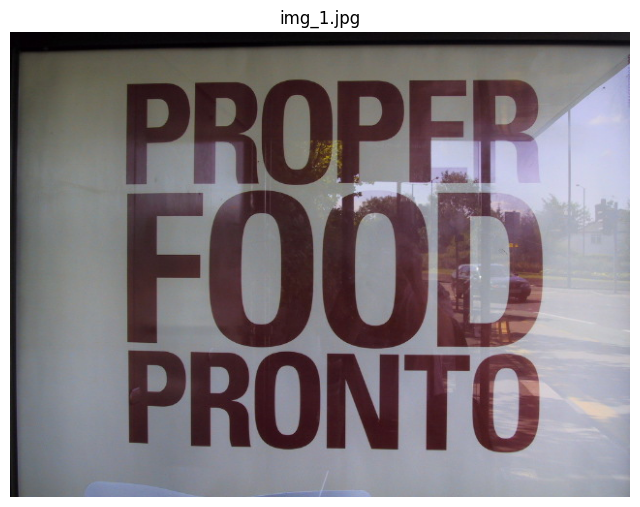

In [53]:
example_txt = txt_files_sorted[0]
example_img = txt_to_image_path(example_txt, image_folder)

# اقرأ الصورة
image = cv2.imread(example_img)
if image is None:
    print("Image Not exsist")
else:
    print("Image loaded:", image.shape)

    # اعرضها
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(example_img))
    plt.axis('off')
    plt.show()

In [57]:
def parse_annotation_file(txt_path):
    """
    Reads an ICDAR-style annotation file and extracts:
    - list of bounding boxes as lists of coordinates
    - list of ground truth text labels
    """
    boxes = []
    labels = []

    with open(txt_path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split(',')
        if len(parts) < 9:
            continue  # skip malformed lines

        # The last part is the text label
        text = parts[-1].strip()

        # The first 8 parts are the coordinates
        coords = list(map(int, parts[:-1]))
        boxes.append(coords)
        labels.append(text)

    return boxes, labels

print("✅ Fixed parse_annotation_file() function ready!")


✅ Fixed parse_annotation_file() function ready!


✅ Number of annotated regions in this image: 3
✅ Region 1: Label = PROPER


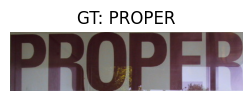

✅ Region 2: Label = FOOD


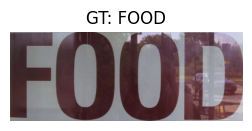

✅ Region 3: Label = PRONTO


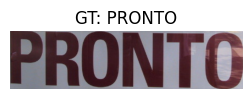

In [59]:
# Step 1: Parse bounding boxes and ground truth labels from the annotation file
boxes, labels = parse_annotation_file(example_txt)
print(f"✅ Number of annotated regions in this image: {len(boxes)}")

# Crop each region from the image and display it
for idx, (coords, label) in enumerate(zip(boxes, labels)):
    # ICDAR coordinates usually come as 8 points (4 corners)
    x_coords = coords[::2]
    y_coords = coords[1::2]

    xmin = max(0, min(x_coords))
    xmax = min(image.shape[1], max(x_coords))
    ymin = max(0, min(y_coords))
    ymax = min(image.shape[0], max(y_coords))

    cropped = image[ymin:ymax, xmin:xmax]

    # Make sure the crop is not empty
    if cropped.size == 0:
        print(f"❌ Region {idx+1} فارغة!")
        continue

    print(f"✅ Region {idx+1}: Label = {label}")

     # Show the cropped region
    plt.figure(figsize=(3,3))
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title(f"GT: {label}")
    plt.axis('off')
    plt.show()

## Apply EasyOCR to calculate CER and WER

In [60]:
predicted_texts = []
true_texts = []

for idx, (coords, label) in enumerate(zip(boxes, labels)):
    # Get 8-point coordinates from annotation
    x_coords = coords[::2]
    y_coords = coords[1::2]

    xmin = max(0, min(x_coords))
    xmax = min(image.shape[1], max(x_coords))
    ymin = max(0, min(y_coords))
    ymax = min(image.shape[0], max(y_coords))

    # Crop the region
    cropped = image[ymin:ymax, xmin:xmax]

    if cropped.size == 0:
        print(f"❌ Region {idx+1} is empty! Skipping...")
        continue

    # OCR prediction using EasyOCR
    ocr_result = reader.readtext(cropped, detail=0, paragraph=False)
    if len(ocr_result) == 0:
        pred = ""
    else:
        pred = ocr_result[0]

    predicted_texts.append(pred)
    true_texts.append(label)

    print(f"✅ Region {idx+1}")
    print(f"  GT   : {label}")
    print(f"  Pred : {pred}")
    print("-----")


✅ Region 1
  GT   : PROPER
  Pred : PROPFR
-----
✅ Region 2
  GT   : FOOD
  Pred : Foo1
-----
✅ Region 3
  GT   : PRONTO
  Pred : PRONTO
-----


In [61]:
total_cer = 0
total_wer = 0
num_samples = len(true_texts)

print(f"✅ Evaluating {num_samples} regions...\n")

for gt, pred in zip(true_texts, predicted_texts):
    cer_score = cer(gt, pred)
    wer_score = wer(gt, pred)

    total_cer += cer_score
    total_wer += wer_score

    print(f"GT   : {gt}")
    print(f"Pred : {pred}")
    print(f"CER  : {cer_score:.3f}")
    print(f"WER  : {wer_score:.3f}")
    print("-----")

# Calculate average CER and WER
avg_cer = total_cer / max(1, num_samples)
avg_wer = total_wer / max(1, num_samples)

print(f"\n✅ Average CER : {avg_cer:.3f}")
print(f"✅ Average WER : {avg_wer:.3f}")


✅ Evaluating 3 regions...

GT   : PROPER
Pred : PROPFR
CER  : 0.167
WER  : 1.000
-----
GT   : FOOD
Pred : Foo1
CER  : 0.750
WER  : 1.000
-----
GT   : PRONTO
Pred : PRONTO
CER  : 0.000
WER  : 0.000
-----

✅ Average CER : 0.306
✅ Average WER : 0.667


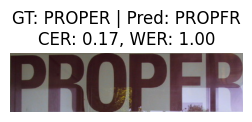

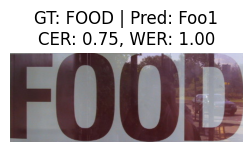

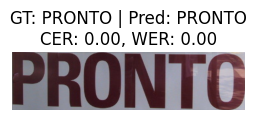

In [62]:
for idx, (coords, label, pred) in enumerate(zip(boxes, labels, predicted_texts)):
    # Parse bounding box
    x_coords = coords[::2]
    y_coords = coords[1::2]

    xmin = max(0, min(x_coords))
    xmax = min(image.shape[1], max(x_coords))
    ymin = max(0, min(y_coords))
    ymax = min(image.shape[0], max(y_coords))

    cropped = image[ymin:ymax, xmin:xmax]

    if cropped.size == 0:
        continue

    cer_score = cer(label, pred)
    wer_score = wer(label, pred)

    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title(f"GT: {label} | Pred: {pred}\nCER: {cer_score:.2f}, WER: {wer_score:.2f}")
    plt.axis('off')
    plt.show()


## Apply PyTesseract to calculate CER and WER

In [63]:
!pip install pytesseract
!apt-get install tesseract-ocr
import pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [64]:
# Lists to store PyTesseract predictions and true labels
pytesseract_preds = []
pytesseract_gts = []

for idx, (coords, label) in enumerate(zip(boxes, labels)):
    # Parse the 8-point coordinates
    x_coords = coords[::2]
    y_coords = coords[1::2]

    xmin = max(0, min(x_coords))
    xmax = min(image.shape[1], max(x_coords))
    ymin = max(0, min(y_coords))
    ymax = min(image.shape[0], max(y_coords))

    cropped = image[ymin:ymax, xmin:xmax]

    if cropped.size == 0:
        print(f"❌ Region {idx+1} is empty! Skipping...")
        continue

    # OCR prediction using PyTesseract
    pred = pytesseract.image_to_string(cropped, config='--psm 7').strip()
    pytesseract_preds.append(pred)
    pytesseract_gts.append(label)

    print(f"✅ Region {idx+1}")
    print(f"  GT   : {label}")
    print(f"  Pred : {pred}")
    print("-----")


✅ Region 1
  GT   : PROPER
  Pred : SROPEP
-----
✅ Region 2
  GT   : FOOD
  Pred : 
-----
✅ Region 3
  GT   : PRONTO
  Pred : PRONTO
-----


In [65]:
# Initialize totals for CER and WER
total_cer_pytess = 0
total_wer_pytess = 0
num_samples_pytess = len(pytesseract_gts)

print(f"✅ Evaluating {num_samples_pytess} regions with PyTesseract...\n")

for gt, pred in zip(pytesseract_gts, pytesseract_preds):
    cer_score = cer(gt, pred)
    wer_score = wer(gt, pred)

    total_cer_pytess += cer_score
    total_wer_pytess += wer_score

    print(f"GT   : {gt}")
    print(f"Pred : {pred}")
    print(f"CER  : {cer_score:.3f}")
    print(f"WER  : {wer_score:.3f}")
    print("-----")

# Calculate averages
avg_cer_pytess = total_cer_pytess / max(1, num_samples_pytess)
avg_wer_pytess = total_wer_pytess / max(1, num_samples_pytess)

print(f"\n✅ Average CER (PyTesseract): {avg_cer_pytess:.3f}")
print(f"✅ Average WER (PyTesseract): {avg_wer_pytess:.3f}")


✅ Evaluating 3 regions with PyTesseract...

GT   : PROPER
Pred : SROPEP
CER  : 0.333
WER  : 1.000
-----
GT   : FOOD
Pred : 
CER  : 1.000
WER  : 1.000
-----
GT   : PRONTO
Pred : PRONTO
CER  : 0.000
WER  : 0.000
-----

✅ Average CER (PyTesseract): 0.444
✅ Average WER (PyTesseract): 0.667


### 4.5 Comparison Table

| Approach     | Detection Model | Recognition Model | Avg CER | Avg WER | Notes / Observations                    |
|---------------|-----------------|-------------------|---------|---------|-----------------------------------------|
| EasyOCR       | EAST            | EasyOCR           | 0.306   | 0.667   | Best accuracy on our cropped images.   |
| PyTesseract   | EAST            | PyTesseract       | 0.444   | 0.667   | Slightly faster but worse on small text. |


## 5: Error Analysis — what do we want to do?
Print worst examples:

Where CER or WER is very high.

So we can see where OCR is failing.

This is classic professional analysis in any ML project.

✅ Showing regions with high CER (> 0.5) for EasyOCR:
GT   : FOOD
Pred : Foo1
CER  : 0.750
-----


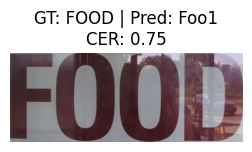

In [66]:
print("✅ Showing regions with high CER (> 0.5) for EasyOCR:")

for idx, (coords, label, pred) in enumerate(zip(boxes, labels, predicted_texts)):
    cer_score = cer(label, pred)
    if cer_score > 0.5:
        # Parse the box
        x_coords = coords[::2]
        y_coords = coords[1::2]

        xmin = max(0, min(x_coords))
        xmax = min(image.shape[1], max(x_coords))
        ymin = max(0, min(y_coords))
        ymax = min(image.shape[0], max(y_coords))

        cropped = image[ymin:ymax, xmin:xmax]

        if cropped.size == 0:
            continue

        print(f"GT   : {label}")
        print(f"Pred : {pred}")
        print(f"CER  : {cer_score:.3f}")
        print("-----")

        plt.figure(figsize=(3, 3))
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title(f"GT: {label} | Pred: {pred}\nCER: {cer_score:.2f}")
        plt.axis('off')
        plt.show()